#

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
import seaborn as sns; sns.set()
import time


In [ ]:
data

### Εισαγωγή dataset από αρχείο CSV

In [ ]:
data = pd.read_csv("./Dry_Bean.csv")

## Εξαγωγή πληροφοριών του dataset

In [ ]:
n_samples=data.shape[0]
n_features = data.shape[1] - 1

In [ ]:
data_array = [[data[key][i] for key in data] for i in range(n_samples)]

In [ ]:
data_array

In [ ]:
x = [i[:-1] for i in data_array]
y = [i[-1] for i in data_array]

In [ ]:
dictForClasses = {k:v for k, v in zip(list(set(data.iloc[:, -1].tolist())), list(range(len(list(set(data.iloc[:, -1].tolist()))))))}

In [67]:
dictForClasses

{'HOROZ': 0,
 'SIRA': 1,
 'BARBUNYA': 2,
 'SEKER': 3,
 'BOMBAY': 4,
 'CALI': 5,
 'DERMASON': 6}

## train-test split

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, shuffle=True)

In [83]:
# hold times for train and pred of out of the box
train_time_base = {}
pred_time_base = {}
# dictionary to store all classifier without optimization preds
predictions = {}

## Εκτέλεση MLP Out-of-the-box

In [84]:
clf = MLPClassifier()
start_time = time.time()
clf.fit(x_train, y_train)
train_time_base["MLP"] = time.time() - start_time
start_time = time.time()
preds = clf.predict(x_test)
pred_time_base["MLP"] = time.time() - start_time
predictions["MLP"] = preds
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

    BARBUNYA       0.00      0.00      0.00       392
      BOMBAY       0.95      0.97      0.96       147
        CALI       0.00      0.00      0.00       484
    DERMASON       1.00      0.14      0.25      1048
       HOROZ       0.16      1.00      0.28       610
       SEKER       0.00      0.00      0.00       602
        SIRA       0.00      0.00      0.00       801

    accuracy                           0.22      4084
   macro avg       0.30      0.30      0.21      4084
weighted avg       0.31      0.22      0.14      4084



C:\Users\ΒΑΣΙΛΗΣ\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ΒΑΣΙΛΗΣ\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ΒΑΣΙΛΗΣ\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.p

## Εκτέλεση SVM Out-of-the-box

In [85]:
from sklearn.svm import SVC # "Support vector classifier"
model = SVC()
start_time = time.time()
model.fit(x_train, y_train)
train_time_base["SVM"] = time.time() - start_time
start_time = time.time()
preds = clf.predict(x_test)
pred_time_base["SVM"] = time.time() - start_time
predictions["SVM"] = preds
print(classification_report(y_test, preds))


              precision    recall  f1-score   support

    BARBUNYA       0.00      0.00      0.00       392
      BOMBAY       0.95      0.97      0.96       147
        CALI       0.00      0.00      0.00       484
    DERMASON       1.00      0.14      0.25      1048
       HOROZ       0.16      1.00      0.28       610
       SEKER       0.00      0.00      0.00       602
        SIRA       0.00      0.00      0.00       801

    accuracy                           0.22      4084
   macro avg       0.30      0.30      0.21      4084
weighted avg       0.31      0.22      0.14      4084



C:\Users\ΒΑΣΙΛΗΣ\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ΒΑΣΙΛΗΣ\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ΒΑΣΙΛΗΣ\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.p

## Dummy Classifiers for scale

In [86]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn.metrics import precision_recall_fscore_support,f1_score

In [87]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

accuracy = {}
f1 = {}

def metrics_info(classifier_name, preds):
  global accuracy, f1 
  accuracy[classifier_name] = accuracy_score(y_test, preds)
  f1[classifier_name] = f1_score(y_test, preds, average = "macro")
  # print bar plot function
def bar_plot(classifiers, scores, title):
  plt.figure(figsize = (10,6))
  y_pos = np.arange(len(classifiers))
  plt.bar(y_pos, scores, align='center', alpha = 0.9)
  plt.xticks(y_pos, classifiers, rotation = 45)
  plt.ylabel('Score')
  plt.title(title)
  plt.show()

                     MLP       SVM  DC Uniform  DC Constant horoz  \
Accuracy Score  0.220617  0.220617    0.136631           0.149363   
F1 Score        0.212430  0.212430    0.129045           0.037129   

                DC Constant sira  DC Constant barbunya  DC Constant seker  \
Accuracy Score          0.196131              0.095984           0.147405   
F1 Score                0.046849              0.025022           0.036705   

                DC Constant bombay  DC Constant cali  DC Constant dermason  \
Accuracy Score            0.035994          0.118511              0.256611   
F1 Score                  0.009927          0.030273              0.058345   

                DC Most Frequent  DC Stratified  
Accuracy Score          0.256611       0.180950  
F1 Score                0.058345       0.150622  


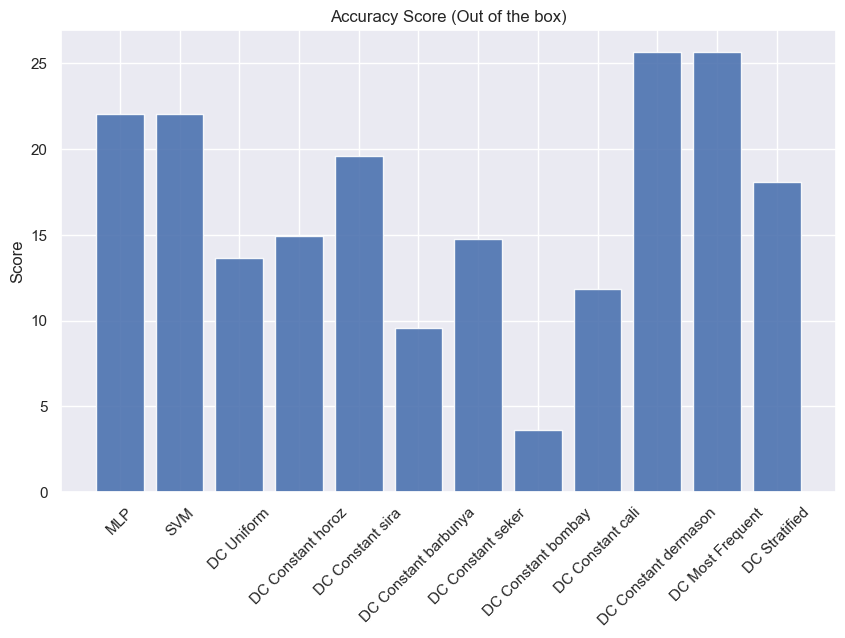

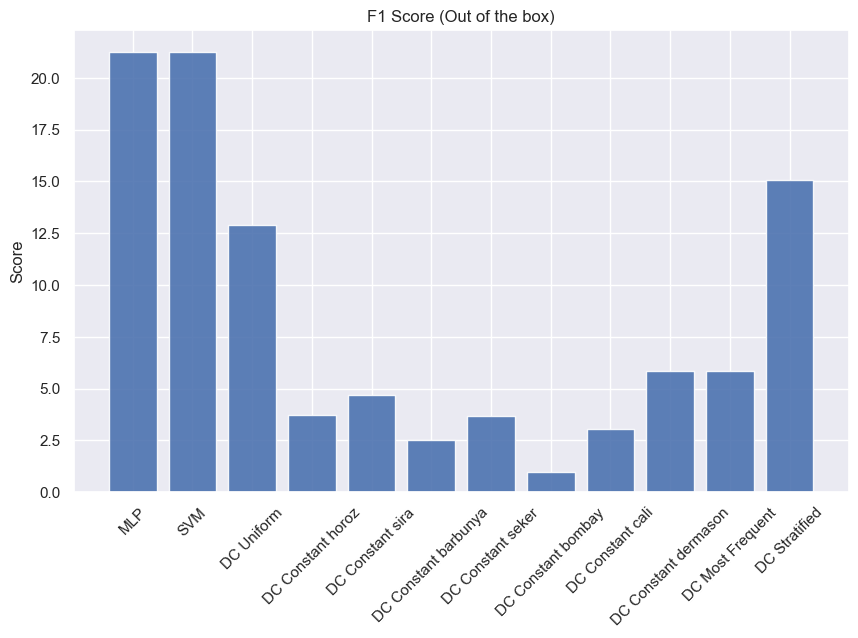

In [89]:
dc_uniform = DummyClassifier(strategy="uniform")
dc_constant_horoz = DummyClassifier(strategy="constant", constant='horoz'.upper())
dc_constant_sira = DummyClassifier(strategy="constant", constant= 'sira'.upper())
dc_constant_barbunya = DummyClassifier(strategy="constant", constant='barbunya'.upper())
dc_constant_seker = DummyClassifier(strategy="constant", constant='seker'.upper())
dc_constant_bombay = DummyClassifier(strategy="constant",constant='bombay'.upper())
dc_constant_cali = DummyClassifier(strategy="constant",constant='cali'.upper())
dc_constant_dermason = DummyClassifier(strategy="constant",constant='dermason'.upper())
dc_most_frequent = DummyClassifier(strategy="most_frequent")
dc_stratified = DummyClassifier(strategy="stratified")

# with the fit method we train the classifier with the train set
# with the predict method predictions occur based on the input data
start_time = time.time()
dc_uniform.fit(x_train, y_train)
train_time_base["DC Uniform"] = time.time() - start_time
start_time = time.time()
predictions["DC Uniform"] = dc_uniform.predict(x_test)
pred_time_base["DC Uniform"] = time.time() - start_time
start_time = time.time()
dc_constant_horoz.fit(x_train, y_train)
train_time_base["DC Constant horoz"] = time.time() - start_time
start_time = time.time()
predictions["DC Constant horoz"] = dc_constant_horoz.predict(x_test)
pred_time_base["DC Constant horoz"] = time.time() - start_time
start_time = time.time()
dc_constant_sira.fit(x_train, y_train)
train_time_base["DC Constant sira"] = time.time() - start_time
start_time = time.time()
predictions["DC Constant sira"] = dc_constant_sira.predict(x_test)
pred_time_base["DC Constant sira"] = time.time() - start_time
start_time = time.time()

start_time = time.time()
dc_constant_bombay.fit(x_train, y_train)
train_time_base["DC Constant bombay"] = time.time() - start_time
start_time = time.time()
predictions["DC Constant bombay"] = dc_constant_bombay.predict(x_test)
pred_time_base["DC Constant bombay"] = time.time() - start_time
start_time = time.time()

start_time = time.time()
dc_constant_cali.fit(x_train, y_train)
train_time_base["DC Constant cali"] = time.time() - start_time
start_time = time.time()
predictions["DC Constant cali"] = dc_constant_cali.predict(x_test)
pred_time_base["DC Constant cali"] = time.time() - start_time
start_time = time.time()

start_time = time.time()
dc_constant_dermason.fit(x_train, y_train)
train_time_base["DC Constant dermason"] = time.time() - start_time
start_time = time.time()
predictions["DC Constant dermason"] = dc_constant_dermason.predict(x_test)
pred_time_base["DC Constant dermason"] = time.time() - start_time
start_time = time.time()

dc_constant_barbunya.fit(x_train, y_train)
train_time_base["DC Constant barbunya"] = time.time() - start_time

start_time = time.time()
predictions["DC Constant barbunya"] = dc_constant_barbunya.predict(x_test)
pred_time_base["DC Constant barbunya"] = time.time() - start_time
start_time = time.time()
dc_constant_seker.fit(x_train, y_train)
train_time_base["DC Constant seker"] = time.time() - start_time
start_time = time.time()
predictions["DC Constant seker"] = dc_constant_seker.predict(x_test)
pred_time_base["DC Constant seker"] = time.time() - start_time
start_time = time.time()
dc_most_frequent.fit(x_train, y_train)
train_time_base["DC Most Frequent"] = time.time() - start_time
start_time = time.time()
predictions["DC Most Frequent"] = dc_most_frequent.predict(x_test)
pred_time_base["DC Most Frequent"] = time.time() - start_time
start_time = time.time()
dc_stratified.fit(x_train, y_train)
train_time_base["DC Stratified"] = time.time() - start_time
start_time = time.time()
predictions["DC Stratified"] = dc_stratified.predict(x_test)
pred_time_base["DC Stratified"] = time.time() - start_time

metrics_info("MLP",predictions["MLP"])
metrics_info("SVM",predictions["SVM"])
metrics_info("DC Uniform", predictions["DC Uniform"])
metrics_info("DC Constant horoz", predictions["DC Constant horoz"])
metrics_info("DC Constant sira", predictions["DC Constant sira"])
metrics_info("DC Constant barbunya", predictions["DC Constant barbunya"])
metrics_info("DC Constant seker", predictions["DC Constant seker"])
metrics_info("DC Constant bombay", predictions["DC Constant bombay"])
metrics_info("DC Constant cali", predictions["DC Constant cali"])
metrics_info("DC Constant dermason", predictions["DC Constant dermason"])
metrics_info("DC Most Frequent", predictions["DC Most Frequent"])
metrics_info("DC Stratified", predictions["DC Stratified"])
classifier_labels = list(accuracy.keys())
classifier_accuracy = list(accuracy.values())
classifier_f1 = list(f1.values())
    
data = []
data.append(list(accuracy.values()))
data.append(list(f1.values()))
print(pd.DataFrame(data, index = ["Accuracy Score", "F1 Score"], columns = list(accuracy.keys())))

bar_plot(classifier_labels, [i*100 for i in classifier_accuracy], "Accuracy Score (Out of the box)")
bar_plot(classifier_labels, [i*100 for i in classifier_f1], "F1 Score (Out of the box)")



## Data cleaning